In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import json
from collections import defaultdict
from typing import Tuple, Dict, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from algos import deep_fib
from common import data
from common import metrics
from common.models import scinet, resnet, deeplab, modutils

plt.style.use("ggplot")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
test_loader = DataLoader(
    data.UnfoldedDataset(
        data.Marconi100Dataset(
            train_test_split(
                data.get_dataset_paths("../data"), test_size=0.1, random_state=42
            )[1],
            scaling=data.Scaling.MINMAX,
        ),
        horizon=1024,
        stride=512,
    ),
    batch_size=64,
    shuffle=False,
)
print(len(test_loader))


Loading: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]

11


In [4]:
SCINET = "scinet"
DEEPLAB = "deeplab"


def get_model(model_name: str, run: str, epoch: int) -> torch.nn.Module:
    model_path = f"./outputs/{run}/models/model_{epoch}.pth"
    if model_name == SCINET:
        cfg_path = f"./outputs/{run}/config.json"
        with open(cfg_path, "r") as f:
            config = json.load(f)

        print(config)
        model = scinet.SCINet(**config).float()
    elif model_name == DEEPLAB:
        model = deeplab.DeepLabNet(
            resnet.ResNetFeatures(
                resnet.Bottleneck,
                resnet.RESNET50_LAYERS,
                return_layers=[resnet.LAYER_1, resnet.LAYER_4],
                replace_stride_with_dilation=[False, True, True],
                num_features=data.NUM_FEATURES,
            ),
            backbone_channels=[256, 2048],
            out_feats=data.NUM_FEATURES,
        ).float()
    else:
        raise ValueError("Wrong model name")

    modutils.load_model(model, model_path, device)
    return model


In [5]:
def get_predictions(model: torch.nn.Module) -> Tuple[torch.Tensor, torch.Tensor]:
    engine = deep_fib.DeepFIBEngine(model, device)
    
    all_errors_ = []
    all_labels_ = []

    for batch in tqdm(test_loader):
        errors = engine.predict(batch["data"])
        all_errors_.append(errors.cpu())
        all_labels_.append(batch["label"])

    all_errors = torch.concat(all_errors_)
    all_labels = torch.concat(all_labels_)

    return all_errors, all_labels


In [6]:
def test_model(model_name: str, run: str, epoch: int) -> None:
    gc.collect()
    model = get_model(model_name, run, epoch)
    errs, labs = get_predictions(model)
    # met = metrics.evaluate_thresholds(errs, labs)
    # metrics.plot_threshold_metrics(met)
    metrics.plot_precision_recall_curve(errs, labs)

{'output_len': 1024, 'input_len': 1024, 'num_encoder_levels': 3, 'hidden_decoder_sizes': [512], 'input_dim': 460, 'hidden_size': 2, 'kernel_size': 3, 'dropout': 0.5}


100%|██████████| 11/11 [00:22<00:00,  2.00s/it]


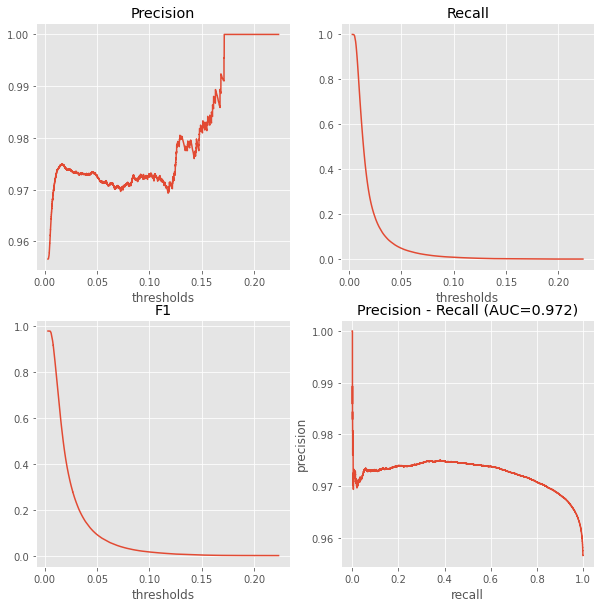

In [7]:
test_model(SCINET, "deep_fib_low_lr", 29)


{'output_len': 1024, 'input_len': 1024, 'num_encoder_levels': 3, 'hidden_decoder_sizes': [512], 'input_dim': 460, 'hidden_size': 2, 'kernel_size': 3, 'dropout': 0.05}


100%|██████████| 11/11 [00:21<00:00,  1.91s/it]


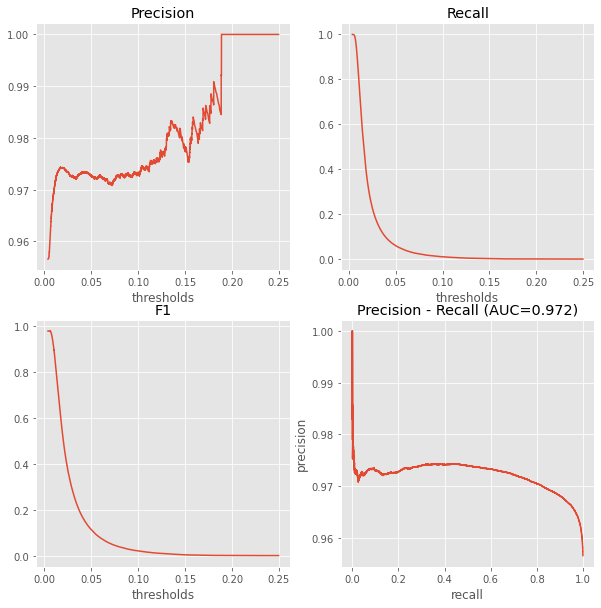

In [8]:
test_model(SCINET, "deep_fib_less_masks", 29)


{'output_len': 1024, 'input_len': 1024, 'num_encoder_levels': 3, 'hidden_decoder_sizes': [512], 'input_dim': 460, 'hidden_size': 2, 'kernel_size': 3, 'dropout': 0.05}


100%|██████████| 11/11 [00:21<00:00,  1.94s/it]


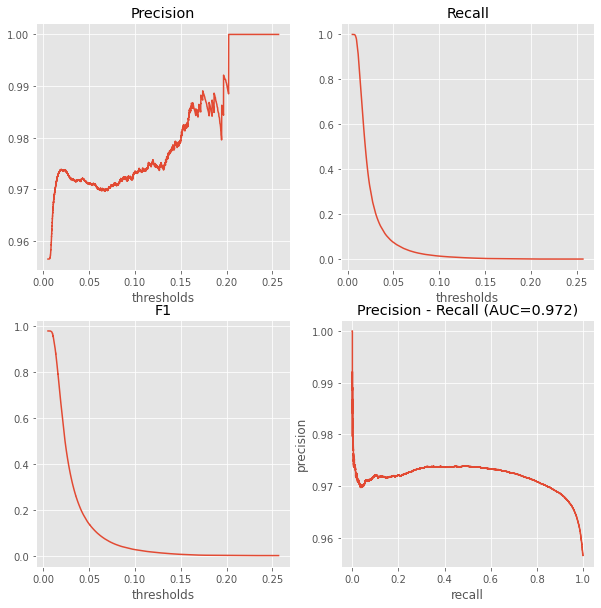

In [9]:
test_model(SCINET, "deep_fib_even_less_masks", 29)


{'output_len': 1024, 'input_len': 1024, 'num_encoder_levels': 3, 'hidden_decoder_sizes': [512], 'input_dim': 460, 'hidden_size': 2, 'kernel_size': 3, 'dropout': 0.05}


100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


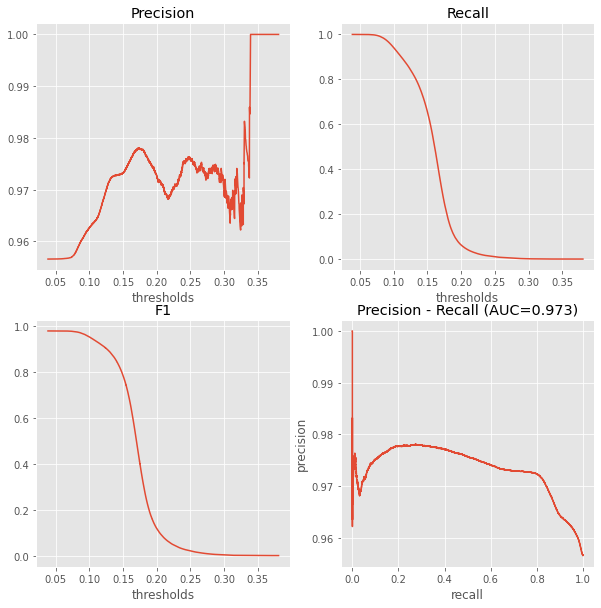

In [10]:
test_model(SCINET, "deep_fib_way_less_masks", 14)


{'output_len': 1024, 'input_len': 1024, 'num_encoder_levels': 3, 'hidden_decoder_sizes': [512], 'input_dim': 460, 'hidden_size': 2, 'kernel_size': 3, 'dropout': 0.5}


100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


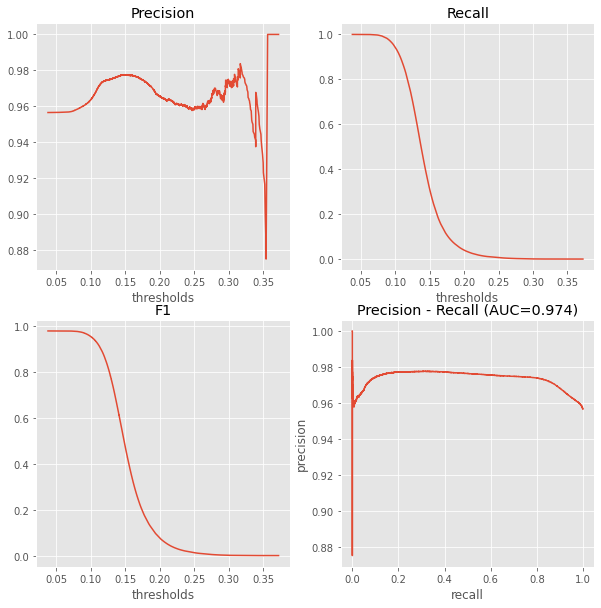

In [11]:
test_model(SCINET, "deep_fib_10_masks_dp", 8)


{'output_len': 1024, 'input_len': 1024, 'num_encoder_levels': 3, 'hidden_decoder_sizes': [512], 'input_dim': 460, 'hidden_size': 2, 'kernel_size': 3, 'dropout': 0.5}


100%|██████████| 11/11 [00:20<00:00,  1.86s/it]


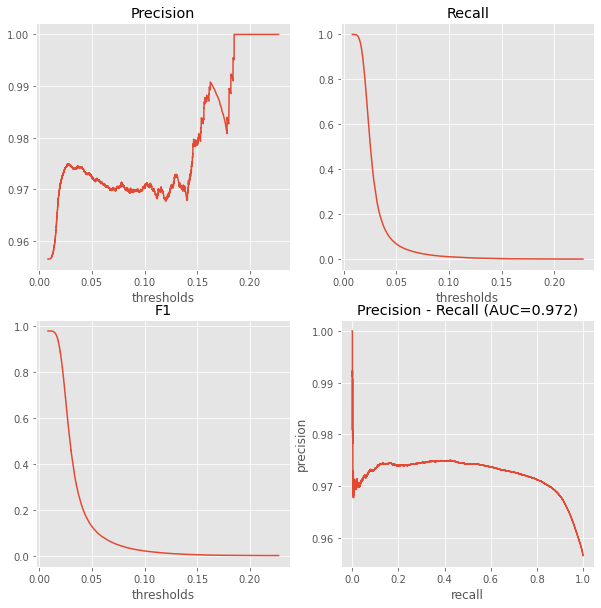

In [12]:
test_model(SCINET, "deep_fib_50_masks_dp", 29)


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


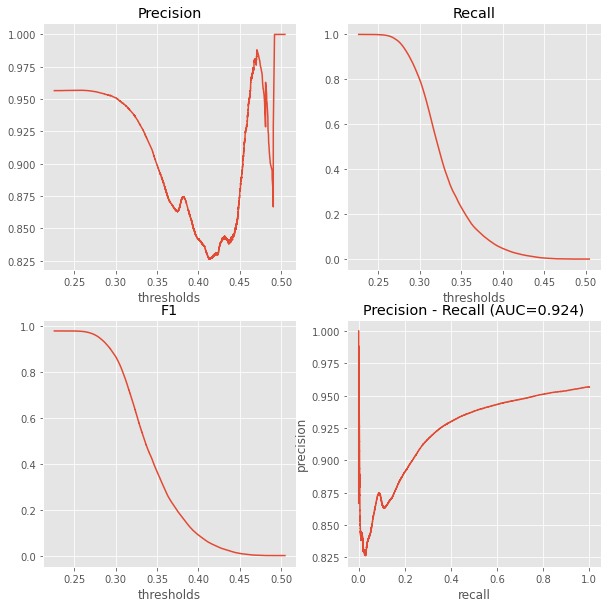

In [13]:
test_model(DEEPLAB, "deep_fib_deeplab_50_masks", 6)

100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


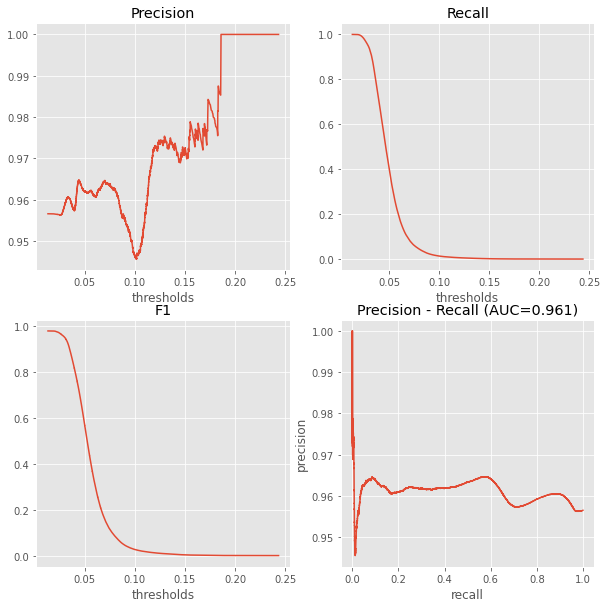

In [14]:
test_model(DEEPLAB, "deep_fib_deeplab_sigmoid", 1)

100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


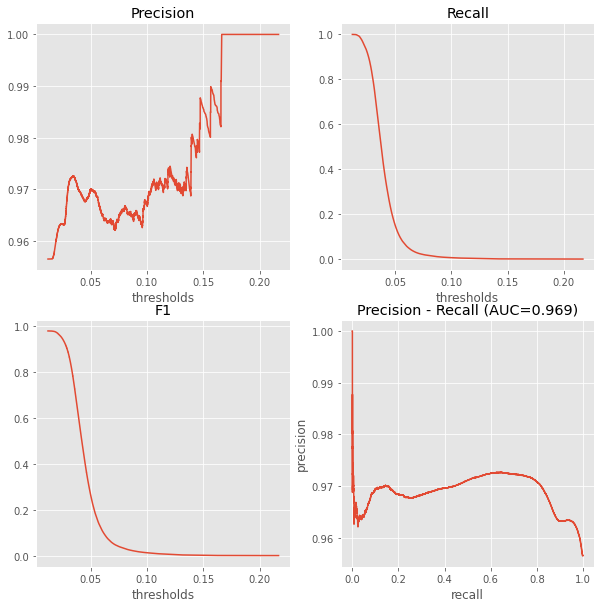

In [15]:
test_model(DEEPLAB, "deep_fib_deeplab_sigmoid", 6)

100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


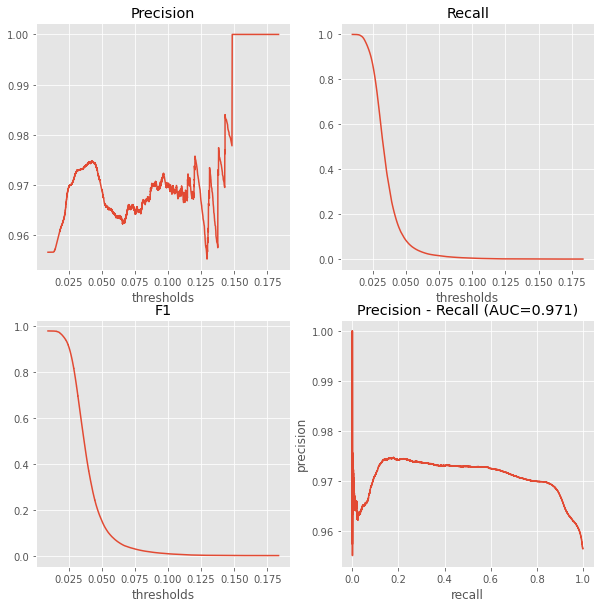

In [16]:
test_model(DEEPLAB, "deep_fib_deeplab_sigmoid", 29)


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


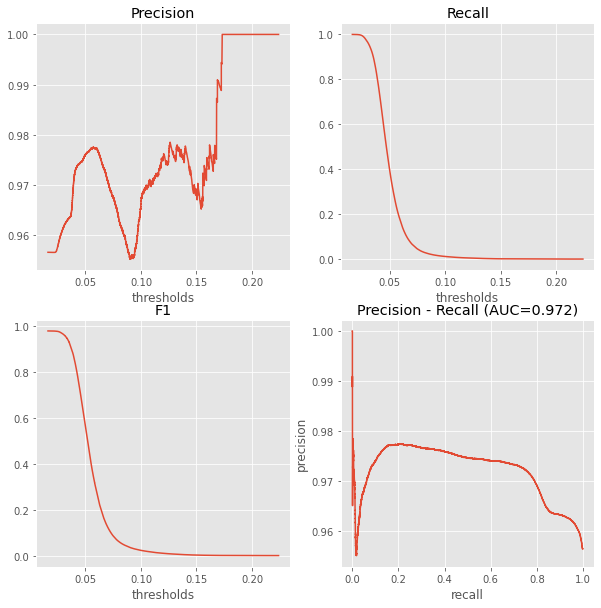

In [17]:
test_model(DEEPLAB, "deep_fib_deeplab_mse", 1)


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


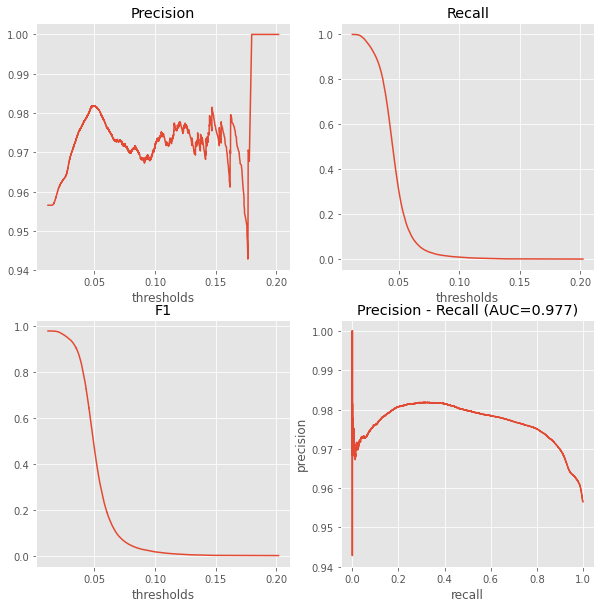

In [18]:
test_model(DEEPLAB, "deep_fib_deeplab_mse", 6)


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


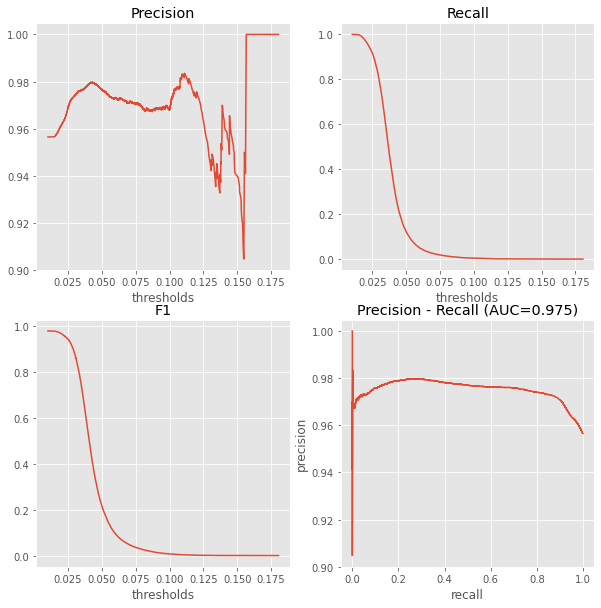

In [19]:
test_model(DEEPLAB, "deep_fib_deeplab_mse", 11)

100%|██████████| 11/11 [00:16<00:00,  1.55s/it]


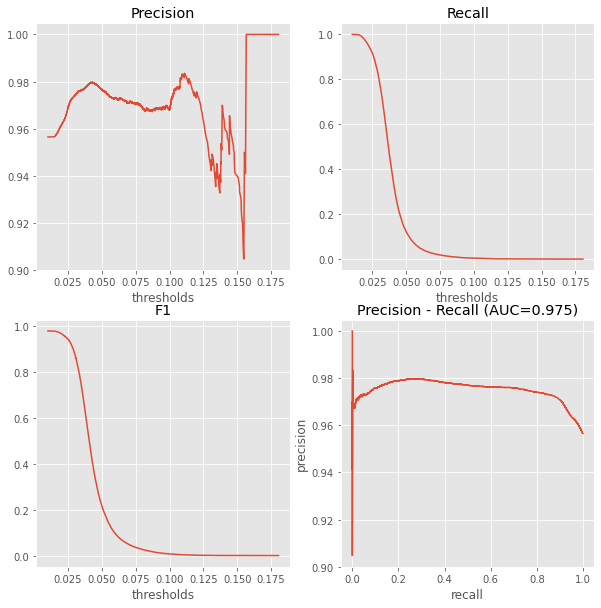

In [20]:
test_model(DEEPLAB, "deep_fib_deeplab_mse", 11)


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


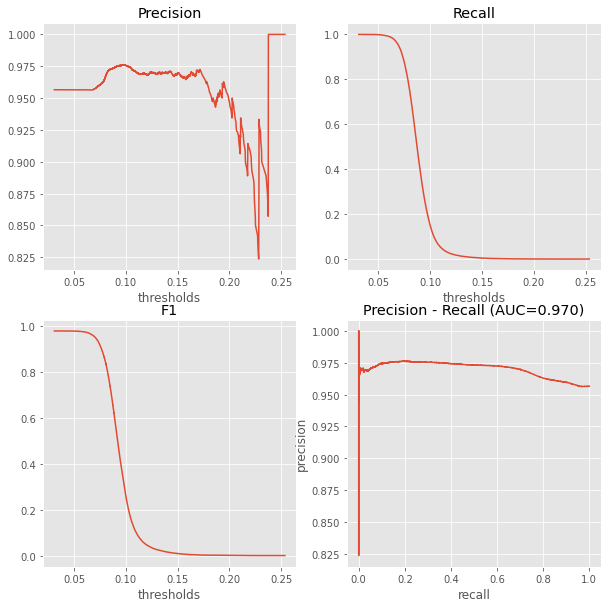

In [21]:
test_model(DEEPLAB, "deep_fib_deeplab_mse_10", 19)


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


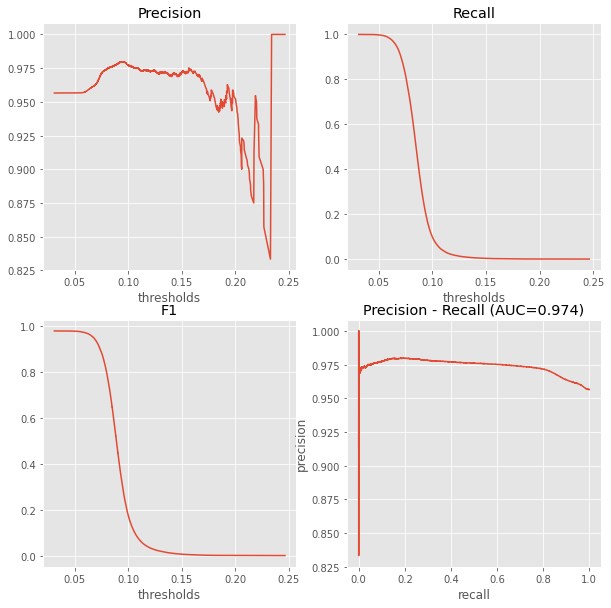

In [22]:
test_model(DEEPLAB, "deep_fib_deeplab_mse_10", 29)


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


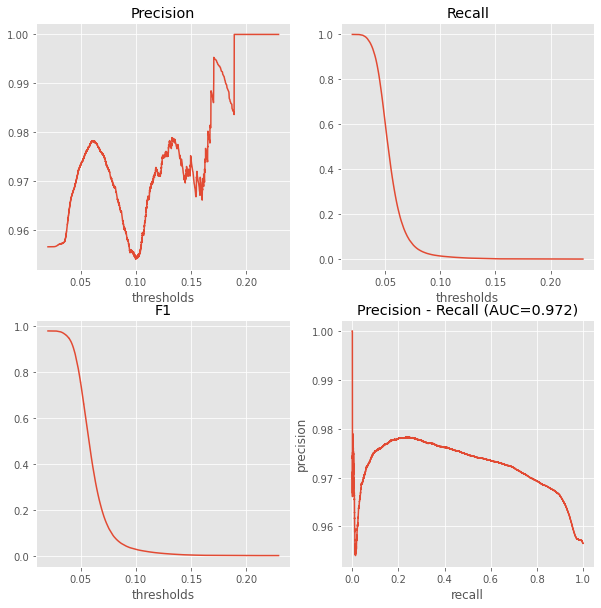

In [23]:
test_model(DEEPLAB, "deep_fib_deeplab_mse_25", 3)


100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


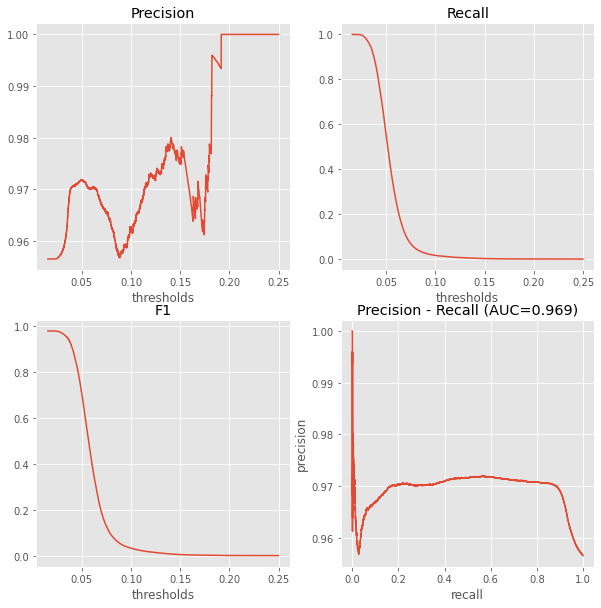

In [24]:
test_model(DEEPLAB, "df_dl_l1_25", 3)